# CNN Prototyping
Dec 2018

Regression based grasp predictor
* Input is black and white image
* Net is 2 conv layers, 3 FC layers
* Output is x,y, theta of grasp

In [1]:
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
IMG_X, IMG_Y = 200,200 
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30

# img_list = []


# Calc rectangle vertices. makeRectangle() credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = './' + dirname  
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        #orient = 0 # degrees
        img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

        # block_l and _w offset so blocks don't run off edge of image 
        rand_x = int(np.random.rand() * (IMG_X-2*block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y-2*block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient) # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                        rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill='white')

        # use a truetype font
        #font = imagefont.truetype("dejavusans.ttf", 15)
        #font = imagefont.truetype("arial.ttf",14)
        #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')
        img.save(newpath + '/rect'+str(i)+'.png')
    return true_coords

train_truth = make_dataset('data1', 1500)
print(len(train_truth))
test_truth = make_dataset('./data1/test', 300)
    
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        #print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample

1500


In [3]:
# Hyper parameters

num_epochs = 20
num_classes = 3 # predicting x,y,orientation
learning_rate = 0.001
batch_size = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data1', coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir='./data1/test', coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                          shuffle=True)



CUDA available? device:  cuda:0


In [4]:
class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16
        
        def _calc(val):
            layer_size = (val- (_stride-1)) / _pool
            return layer_size 
        
        #print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers 
        #print(self._const)
        self._const = int(self._const)
        
        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)
        

    def forward(self, x):
        #print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net(IMG_X, IMG_Y)
model = model.to(device)

# ONLY FOR DEBUGGING (check if code runs at all)
#images = iter(train_loader)
##outputs = model(images.next()[0])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
losses_list = []
ct = 0
print('Training model now...')
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print('This is batch', i_batch, ' with len images ', len(images))

        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        #if (i_batch+1) % 1 == 0:
        if (i_batch) % 25 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))
        losses_list.append(loss.item())

Training model now...
Epoch [1/20], Step [1/47], Loss: 7477.4780
Epoch [1/20], Step [26/47], Loss: 199.8231
Epoch [2/20], Step [1/47], Loss: 112.1143
Epoch [2/20], Step [26/47], Loss: 33.0154
Epoch [3/20], Step [1/47], Loss: 16.2047
Epoch [3/20], Step [26/47], Loss: 16.7992
Epoch [4/20], Step [1/47], Loss: 7.2733
Epoch [4/20], Step [26/47], Loss: 7.4274
Epoch [5/20], Step [1/47], Loss: 3.2121
Epoch [5/20], Step [26/47], Loss: 3.7564
Epoch [6/20], Step [1/47], Loss: 3.7327
Epoch [6/20], Step [26/47], Loss: 2.5129
Epoch [7/20], Step [1/47], Loss: 2.6528
Epoch [7/20], Step [26/47], Loss: 2.6656
Epoch [8/20], Step [1/47], Loss: 1.4304
Epoch [8/20], Step [26/47], Loss: 2.2827
Epoch [9/20], Step [1/47], Loss: 1.6282
Epoch [9/20], Step [26/47], Loss: 1.1718
Epoch [10/20], Step [1/47], Loss: 1.5665
Epoch [10/20], Step [26/47], Loss: 1.9583
Epoch [11/20], Step [1/47], Loss: 0.9557
Epoch [11/20], Step [26/47], Loss: 1.3573
Epoch [12/20], Step [1/47], Loss: 1.3503
Epoch [12/20], Step [26/47], Los

# evaluate

In [6]:
# alert when training is done
sound_file = '/home/rui/Downloads/newyear.ogg'
Audio(sound_file, autoplay=True)

940


(0, 100)

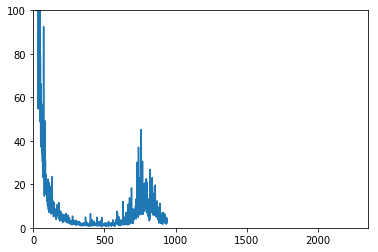

In [7]:
plt.plot(range(len(losses_list)), losses_list)
print(len(losses_list))
plt.xlim([0,2350])
plt.ylim([0,100])

In [8]:
model.to(device).eval()  
# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# evaluation: MSE loss of center predictions
# evaluation: MSE loss of degree predictions
criterion = nn.MSELoss()


print(len(test_loader))
print(len(train_loader))
print(len(test_loader))
print(len(test_loader))

with torch.no_grad():
    total_err = 0
    n_total = 0
    for i_batch, (images, labels) in enumerate(test_loader):
    #for i_batch, (images, labels) in enumerate(train_loader):
        print('i_batch', i_batch)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        diff = outputs - labels
        diff = torch.sum(diff, 0) #column sum
        total_err += diff
        #loss = criterion(outputs, labels)
        #print(loss)
        #x, y, orient = outputs.squeeze() # remove extra dim, so not nested list of list
        #true_x, true_y, true_orient = labels.squeeze()
        #xy_err +=criterion( torch.Tensor([x,y]), torch.Tensor([true_x, true_y]))
        #orient_err += criterion(orient, true_orient)
        #print(n_total)
        #n_total += 1
        #_, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
print(n_total * batch_size)

10
47
10
10
i_batch 0
i_batch 1
i_batch 2
i_batch 3
i_batch 4
i_batch 5
i_batch 6
i_batch 7
i_batch 8
i_batch 9
0


300


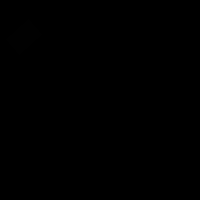

tensor([ -18.4041,  -55.3324, -107.2684], device='cuda:0')
tensor([-0.0613, -0.1844, -0.3576], device='cuda:0')

 ----------------------------
Across a total of 300 images, the average error was -0.06 and -0.18 pixels for x and y, and -20.49 degrees for orientation

 ----------------------------


In [20]:
n_total = len(test_loader.dataset)

print(n_total)
from IPython.display import display # to display images

import torchvision
img = torchvision.transforms.ToPILImage()(images[0].cpu())
display(img)

avg_err = total_err / n_total 
print(total_err)
print(avg_err)
xerr, yerr, orienterr = avg_err
print('\n ----------------------------')
print('Across a total of %d images, the average error was %0.2f and %0.2f pixels for x and y, \
and %0.2f degrees for orientation' % (n_total, xerr, yerr, math.degrees(orienterr)))
print('\n ----------------------------')

# diagnostics

In [21]:
from IPython.display import display # to display images
#font = ImageFont.truetype("Arial.ttf",14) # OSError: cannot open resource
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf",14)
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    #draw.text((10, 25), '(' + np.array2string(np.around(a_label.numpy()), separator=', ') + ')')
    x,y,orient = a_label
    rect_vertices = makeRectangle(5, 15, orient, offset=(x,y))
    draw.polygon(rect_vertices, fill='red')
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b, orient = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

x,y truth tensor([173.0000,  62.0000,   0.1222])
x,y guess by net tensor([174.0024,  61.5729,   1.7711], device='cuda:0')
image size:  torch.Size([3, 200, 200])
tensor(15.1495, device='cuda:0')
net output: 


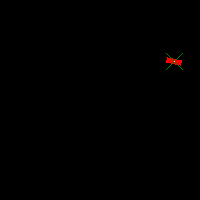

truth label: 


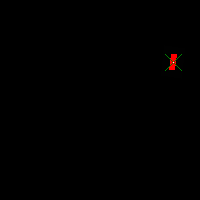

In [22]:
import torchvision 
import matplotlib.pyplot as plt
import copy
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))


    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
        
    loss = criterion(outputs.to(device), labels.to(device))
 
n =0 
#print(len(labels))
print('x,y truth', labels[n])
print('x,y guess by net', outputs[n])

images_copy = copy.deepcopy(images)
print('image size: ', images_copy[n].size())
print(loss)
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])

#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#print('PIL image size', imagePIL.size)
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

tensor([[29.1645, 60.5914,  1.7110]], device='cuda:0')


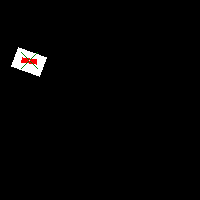

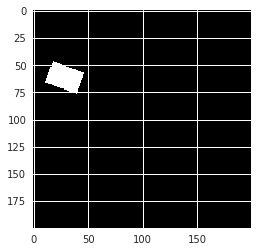

In [24]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 12
n = np.random.rand()*len(images)
n = int(n)

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
#coords = torch.FloatTensor(true_coords[n])
with torch.no_grad():
    output = model(image_tensor)

#print(true_coords[n])
print(output)
x,y,orient = output.cpu().numpy().flatten()
imshow_coord(image, (x,y, orient))
plt.imshow(image)

torch.Size([32, 3, 200, 200])
tensor(255.) tensor(0.) torch.Size([3, 810, 1618])
(810, 1618, 3)
3
x,y guess by net tensor([174.0024,  61.5729,   1.7711], device='cuda:0')


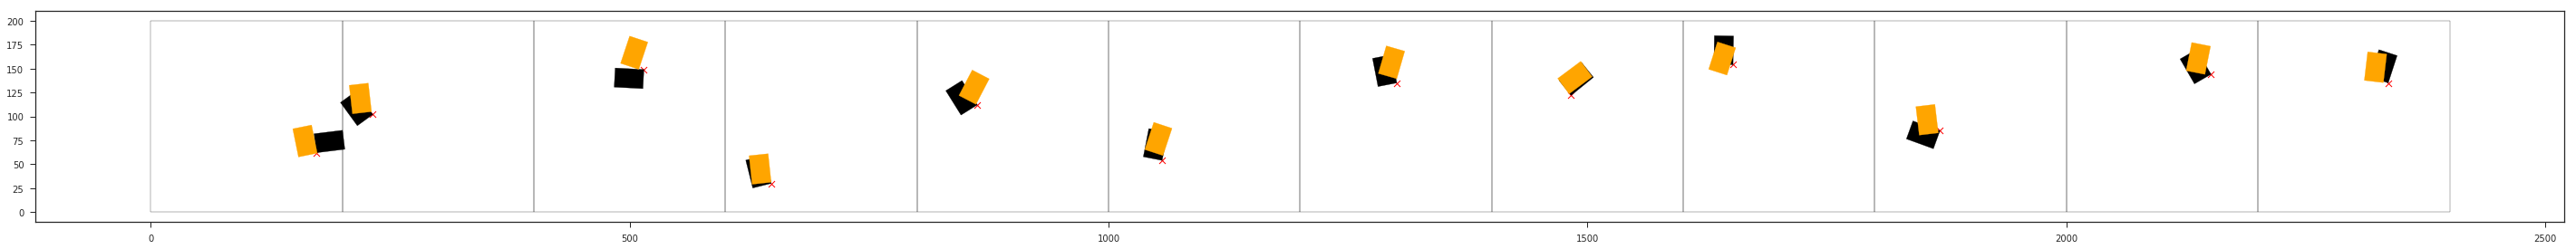

In [85]:
#img = Image.new('RGB', (300,400), 'gray')
import seaborn as sns
sns.set_style("ticks")
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize

a = a.cpu().numpy()
a = np.transpose(a,(1,2,0))
print(a.shape)
print(a.ndim)

#ran = a.max() - a.min()
#a = (a/ran )
plt.rcParams['figure.figsize'] = [50,10]

fig,ax = plt.isubplots()
# Display the image
#x,y = labels[0].numpy()
#plt.scatter(x,y, color='g', marker='x', linewidth='1')
labels = labels.cpu()
print('x,y guess by net', outputs[n])

import matplotlib.patches as patches
for i in range(len(labels)-20):
    x,y, orient = labels[i].numpy()
    x1, y1, orient1 = outputs[i].cpu().numpy()
    
    orient = np.rad2deg(orient)
    orient1 = np.rad2deg(orient1)
    
# class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
    #rect = patches.Rectangle((IMG_X, y), 30,20,angle=orient, fill=True, color='orange')
    rect = patches.Rectangle((x+i*IMG_X, y), 30,20,angle=orient, fill=True, color='black')
    rect1 = patches.Rectangle((x1+i*IMG_X, y1), 30,20,angle=orient1, fill=True, color='orange')
    rect2 = patches.Rectangle((i*IMG_X, 0), 200, 200,angle=0, fill=False, color='black')
    ax.add_patch(rect)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.scatter(x + i*IMG_X, y, color='r', marker='x', linewidth='1')
#plt.imshow(np.transpose(a, (2,0,1)))
ax.set_aspect('equal', 'box')
plt.show()
#ax.imshow(a)

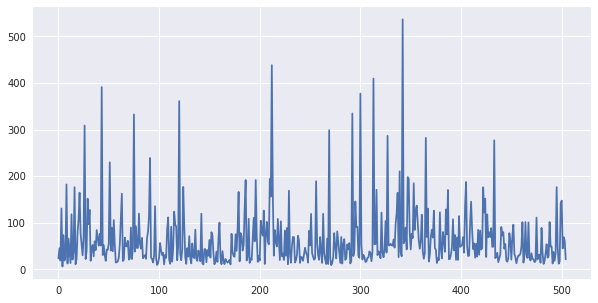

In [59]:
import seaborn as sns
sns.set()
f = plt.subplot()
f.plot(range(len(losses_list)), losses_list)

plt.rcParams['figure.figsize'] = [30, 5]
xposition = np.array(range(num_epoch))  * (total_step)
#print(xposition)
for xc in xposition:
    
    #plt.axvline(x=xc, color='k', linestyle='--')
    pass
    


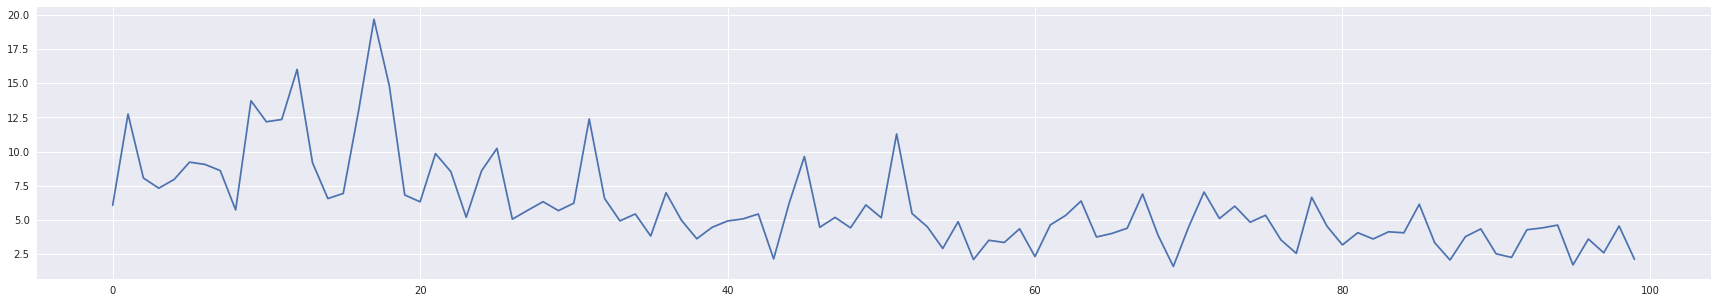

In [18]:
g = plt.subplot()
trunc = 100
g.plot(range(trunc), losses_list[-trunc:])

plt.show()

# Don't run the following cell (takes long time)

In [19]:
num_epochs = [10,20,50,70,100,150] 
num_classes = 3 # predicting x,y,orientation
batch_size = 5 
learning_rates = [0.001, 0.005, 0.01, 0.1]

meta_losses_list = []
for i in range(len(num_epochs)):
    num_epoch = num_epochs[i]
    learning_rate = learning_rates[0]
    losses_list = []
    print('Training model now... with: %d num_epoch and %d learning rate' % (num_epoch, learning_rate))
    
    total_step = len(train_loader)
    for epoch in range(num_epoch):
        for i_batch, (images, labels) in enumerate(train_loader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            # magnify orientation loss
            outputs[2] *= 10
            labels[2] *= 10
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            if (i_batch+1) % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                          num_epochs,
                                                                          i_batch+1,
                                                                          total_step,
                                                                          loss.item()))
                losses_list.append(loss.item())
    meta_losses_list.append(losses_list)

Training model now... with: 10 num_epoch and 0 learning rate
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [1/47], Loss: 4.6906
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [2/47], Loss: 30.1758
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [3/47], Loss: 212.8980
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [4/47], Loss: 363.2415
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [5/47], Loss: 2723.5322
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [6/47], Loss: 2478.3079
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [7/47], Loss: 1340.2832
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [8/47], Loss: 10507.5762
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [9/47], Loss: 5108.5259
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [10/47], Loss: 1644.4984
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [11/47], Loss: 3292.8660
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [12/47], Loss: 3472.1211
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [13/47], Loss: 11311.1748
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [14/47], Loss: 1214.5792
E

Epoch [3/[10, 20, 50, 70, 100, 150]], Step [31/47], Loss: 3749.3323
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [32/47], Loss: 148.6818
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [33/47], Loss: 184.5459
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [34/47], Loss: 195.8508
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [35/47], Loss: 138.1251
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [36/47], Loss: 678.6237
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [37/47], Loss: 301.5959
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [38/47], Loss: 1160.6074
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [39/47], Loss: 358.2061
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [40/47], Loss: 141.4762
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [41/47], Loss: 283.4752
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [42/47], Loss: 1059.9498
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [43/47], Loss: 427.4983
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [44/47], Loss: 201.7580
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [45/47], Loss: 1

Epoch [6/[10, 20, 50, 70, 100, 150]], Step [16/47], Loss: 485.5142
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [17/47], Loss: 923.3692
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [18/47], Loss: 410.0955
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [19/47], Loss: 592.7464
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [20/47], Loss: 2035.5734
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [21/47], Loss: 800.0913
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [22/47], Loss: 164.6873
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [23/47], Loss: 274.9424
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [24/47], Loss: 140.7726
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [25/47], Loss: 435.2782
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [26/47], Loss: 326.4024
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [27/47], Loss: 521.8432
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [28/47], Loss: 1407.2720
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [29/47], Loss: 408.2281
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [30/47], Loss: 45

Epoch [9/[10, 20, 50, 70, 100, 150]], Step [1/47], Loss: 164.4717
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [2/47], Loss: 80.8179
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [3/47], Loss: 258.8535
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [4/47], Loss: 312.6396
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [5/47], Loss: 1229.2449
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [6/47], Loss: 36.9498
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [7/47], Loss: 117.2980
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [8/47], Loss: 77.0078
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [9/47], Loss: 107.4487
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [10/47], Loss: 34.1371
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [11/47], Loss: 746.5114
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [12/47], Loss: 129.0283
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [13/47], Loss: 55.5332
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [14/47], Loss: 87.9775
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [15/47], Loss: 187.3888
Epoch [9/

Epoch [1/[10, 20, 50, 70, 100, 150]], Step [33/47], Loss: 182.5460
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [34/47], Loss: 184.5678
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [35/47], Loss: 120.9750
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [36/47], Loss: 54.3237
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [37/47], Loss: 82.8932
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [38/47], Loss: 151.6248
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [39/47], Loss: 134.8582
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [40/47], Loss: 96.6509
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [41/47], Loss: 46.4959
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [42/47], Loss: 69.0384
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [43/47], Loss: 60.1836
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [44/47], Loss: 203.0851
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [45/47], Loss: 386.4507
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [46/47], Loss: 104.3293
Epoch [1/[10, 20, 50, 70, 100, 150]], Step [47/47], Loss: 209.8464
E

Epoch [4/[10, 20, 50, 70, 100, 150]], Step [18/47], Loss: 60.0974
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [19/47], Loss: 55.1636
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [20/47], Loss: 30.0175
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [21/47], Loss: 227.8199
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [22/47], Loss: 106.9125
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [23/47], Loss: 102.7448
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [24/47], Loss: 119.2063
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [25/47], Loss: 24.2663
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [26/47], Loss: 224.7622
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [27/47], Loss: 48.9621
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [28/47], Loss: 86.3279
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [29/47], Loss: 29.8140
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [30/47], Loss: 241.9512
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [31/47], Loss: 35.4536
Epoch [4/[10, 20, 50, 70, 100, 150]], Step [32/47], Loss: 41.7965
Epoc

Epoch [7/[10, 20, 50, 70, 100, 150]], Step [3/47], Loss: 28.5855
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [4/47], Loss: 79.7155
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [5/47], Loss: 137.1050
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [6/47], Loss: 34.0586
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [7/47], Loss: 55.1827
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [8/47], Loss: 145.2306
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [9/47], Loss: 207.2137
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [10/47], Loss: 199.4312
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [11/47], Loss: 332.8647
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [12/47], Loss: 61.9899
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [13/47], Loss: 141.4746
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [14/47], Loss: 92.5803
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [15/47], Loss: 81.9295
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [16/47], Loss: 162.1840
Epoch [7/[10, 20, 50, 70, 100, 150]], Step [17/47], Loss: 29.5820
Epoch [7/[

Epoch [9/[10, 20, 50, 70, 100, 150]], Step [35/47], Loss: 72.1598
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [36/47], Loss: 117.1950
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [37/47], Loss: 58.3103
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [38/47], Loss: 127.0484
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [39/47], Loss: 74.2102
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [40/47], Loss: 40.8993
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [41/47], Loss: 37.0199
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [42/47], Loss: 34.7708
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [43/47], Loss: 24.3547
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [44/47], Loss: 132.6823
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [45/47], Loss: 58.5505
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [46/47], Loss: 144.5065
Epoch [9/[10, 20, 50, 70, 100, 150]], Step [47/47], Loss: 84.8369
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [1/47], Loss: 20.7397
Epoch [10/[10, 20, 50, 70, 100, 150]], Step [2/47], Loss: 28.2887
Epoch 

Epoch [12/[10, 20, 50, 70, 100, 150]], Step [20/47], Loss: 137.3244
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [21/47], Loss: 50.9882
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [22/47], Loss: 37.0463
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [23/47], Loss: 35.7522
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [24/47], Loss: 69.5989
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [25/47], Loss: 27.0098
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [26/47], Loss: 26.2480
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [27/47], Loss: 102.6942
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [28/47], Loss: 84.4295
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [29/47], Loss: 46.5702
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [30/47], Loss: 19.1284
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [31/47], Loss: 51.2268
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [32/47], Loss: 22.1828
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [33/47], Loss: 64.1626
Epoch [12/[10, 20, 50, 70, 100, 150]], Step [34/47], Loss: 2

Epoch [15/[10, 20, 50, 70, 100, 150]], Step [5/47], Loss: 193.9822
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [6/47], Loss: 51.2361
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [7/47], Loss: 35.5903
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [8/47], Loss: 31.7662
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [9/47], Loss: 22.4470
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [10/47], Loss: 66.8270
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [11/47], Loss: 91.3550
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [12/47], Loss: 78.8906
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [13/47], Loss: 122.7754
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [14/47], Loss: 187.4767
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [15/47], Loss: 124.7699
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [16/47], Loss: 285.9720
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [17/47], Loss: 25.4316
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [18/47], Loss: 24.8858
Epoch [15/[10, 20, 50, 70, 100, 150]], Step [19/47], Loss: 26.

Epoch [17/[10, 20, 50, 70, 100, 150]], Step [37/47], Loss: 29.1155
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [38/47], Loss: 97.1410
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [39/47], Loss: 41.1274
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [40/47], Loss: 31.1846
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [41/47], Loss: 20.3650
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [42/47], Loss: 14.2737
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [43/47], Loss: 62.0247
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [44/47], Loss: 23.5233
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [45/47], Loss: 55.4417
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [46/47], Loss: 104.7632
Epoch [17/[10, 20, 50, 70, 100, 150]], Step [47/47], Loss: 27.6548
Epoch [18/[10, 20, 50, 70, 100, 150]], Step [1/47], Loss: 78.7576
Epoch [18/[10, 20, 50, 70, 100, 150]], Step [2/47], Loss: 13.5762
Epoch [18/[10, 20, 50, 70, 100, 150]], Step [3/47], Loss: 31.4640
Epoch [18/[10, 20, 50, 70, 100, 150]], Step [4/47], Loss: 26.086

Epoch [20/[10, 20, 50, 70, 100, 150]], Step [21/47], Loss: 143.9268
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [22/47], Loss: 45.8690
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [23/47], Loss: 310.4106
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [24/47], Loss: 53.6709
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [25/47], Loss: 43.5657
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [26/47], Loss: 25.0274
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [27/47], Loss: 22.5034
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [28/47], Loss: 54.0513
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [29/47], Loss: 9.9218
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [30/47], Loss: 20.7101
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [31/47], Loss: 198.2413
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [32/47], Loss: 23.2717
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [33/47], Loss: 35.5076
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [34/47], Loss: 38.2843
Epoch [20/[10, 20, 50, 70, 100, 150]], Step [35/47], Loss: 5

Epoch [3/[10, 20, 50, 70, 100, 150]], Step [6/47], Loss: 13.0976
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [7/47], Loss: 25.5528
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [8/47], Loss: 56.7928
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [9/47], Loss: 40.0249
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [10/47], Loss: 30.8869
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [11/47], Loss: 35.8473
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [12/47], Loss: 10.7806
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [13/47], Loss: 31.0594
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [14/47], Loss: 25.0078
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [15/47], Loss: 85.0086
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [16/47], Loss: 111.7633
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [17/47], Loss: 21.3091
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [18/47], Loss: 12.1531
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [19/47], Loss: 91.7025
Epoch [3/[10, 20, 50, 70, 100, 150]], Step [20/47], Loss: 16.7541
Epoch [3/[10,

Epoch [5/[10, 20, 50, 70, 100, 150]], Step [38/47], Loss: 83.6581
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [39/47], Loss: 29.3148
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [40/47], Loss: 88.8173
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [41/47], Loss: 11.4053
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [42/47], Loss: 168.9147
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [43/47], Loss: 33.9052
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [44/47], Loss: 14.4676
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [45/47], Loss: 51.0336
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [46/47], Loss: 69.8062
Epoch [5/[10, 20, 50, 70, 100, 150]], Step [47/47], Loss: 69.3456
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [1/47], Loss: 14.9527
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [2/47], Loss: 19.7784
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [3/47], Loss: 31.2322
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [4/47], Loss: 72.3688
Epoch [6/[10, 20, 50, 70, 100, 150]], Step [5/47], Loss: 61.2609
Epoch [6/[10, 

Epoch [8/[10, 20, 50, 70, 100, 150]], Step [23/47], Loss: 76.8746
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [24/47], Loss: 67.4315
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [25/47], Loss: 184.6626
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [26/47], Loss: 84.8845
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [27/47], Loss: 126.1043
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [28/47], Loss: 136.9904
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [29/47], Loss: 100.1789
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [30/47], Loss: 62.4168
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [31/47], Loss: 44.3354
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [32/47], Loss: 61.1390
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [33/47], Loss: 117.4554
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [34/47], Loss: 38.4579
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [35/47], Loss: 22.9733
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [36/47], Loss: 34.5490
Epoch [8/[10, 20, 50, 70, 100, 150]], Step [37/47], Loss: 282.3821
Epoc

Epoch [11/[10, 20, 50, 70, 100, 150]], Step [7/47], Loss: 21.4947
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [8/47], Loss: 29.6161
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [9/47], Loss: 31.9768
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [10/47], Loss: 14.5255
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [11/47], Loss: 89.1313
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [12/47], Loss: 35.6798
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [13/47], Loss: 11.9903
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [14/47], Loss: 18.3498
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [15/47], Loss: 34.3427
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [16/47], Loss: 54.3571
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [17/47], Loss: 25.3251
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [18/47], Loss: 28.8205
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [19/47], Loss: 101.7493
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [20/47], Loss: 49.1157
Epoch [11/[10, 20, 50, 70, 100, 150]], Step [21/47], Loss: 49.07

KeyboardInterrupt: 

In [ ]:
fig = plt.subplots()
trunc = 100
for l in meta_losses_list:
    plt.plot(range(len(l[-trunc:])), l[-trunc:])
plt.legend()
plt.show()